In [1]:
import pandas as pd
import numpy as np

import altair as alt
import hela.visualization.hmm as hmmplot
import matplotlib.pyplot as plt
%matplotlib inline

from hela import hmm
import hela.generation.hmm as gen
from scipy.special import logsumexp

from datetime import datetime
from dask.distributed import Client

TU_COLORS = [
    "#9b67ff", "#57b3c2", "#ffa040", "#ff6283", "#2ccc72", "#1270cb", "#bd043a",
    "#a1c54d", "#4c319e", "#c6c0fe", "#195036", "#f6a39f"
]

### Factored HMM Generative

In [2]:
# factored_generative_model = gen.FactoredHMMGenerativeModel(
#                                      ns_hidden_states =[2, 2],
#                                      n_gaussian_features = 2,
#                                      n_categorical_features = 1)

In [3]:
# factored_hidden_states = factored_generative_model.generate_hidden_state_sequence(n_observations = 50)

In [4]:
# fhmm_data = factored_generative_model.generate_observations(factored_hidden_states)

In [5]:
# fhmm_training_spec = factored_generative_model.generative_model_to_discrete_fhmm_training_spec()
# fhmm_training_spec

In [6]:
# model_config = hmm.DiscreteFHMMConfiguration.from_spec(fhmm_training_spec)
# model_config

### HMM Generative

In [7]:
generative_model = gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states =3,
                                     n_gaussian_features=0,
                                    n_categorical_features = 2,
                                     n_gmm_components = None)

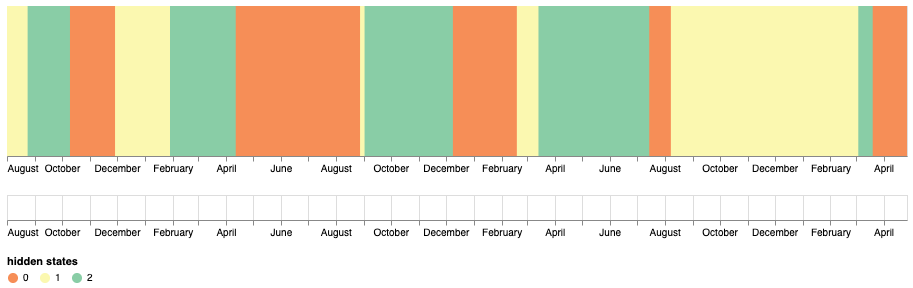

In [8]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)
hmmplot.draw_states(hidden_states, hide_brush=False)

In [9]:
hmm_data = generative_model.generate_observations(hidden_states)
hmm_data.head()

,categorical_feature_0,categorical_feature_1
2020-08-01,1,2
2020-08-02,0,0
2020-08-03,0,0
2020-08-04,0,0
2020-08-05,0,0


In [10]:
hmm_training_spec = generative_model.generative_model_to_discrete_hmm_training_spec()

In [11]:
model_config = hmm.DiscreteHMMConfiguration.from_spec(hmm_training_spec)

In [12]:
hmm_model = model_config.to_model()

### HMM - DBN parameters

In [13]:
# emission matrix
emission = np.exp(np.array(hmm_model.categorical_model.log_emission_matrix))

# transition matrix
transition_matrix = hmm_training_spec['model_parameter_constraints']['transition_constraints']

# initial state
p_init = hmm_training_spec['model_parameter_constraints']['initial_state_constraints']
p_init = np.array(p_init).reshape((3,1))

In [14]:
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.factors.discrete import TabularCPD

from collections import namedtuple
import itertools

import networkx as nx
import numpy as np
from tqdm import tqdm

from pgmpy.factors import factor_product
from pgmpy.inference import Inference
from pgmpy.models import BayesianModel, MarkovChain, MarkovModel
from pgmpy.utils.mathext import sample_discrete
from pgmpy.sampling import _return_samples
from pgmpy.global_vars import SHOW_PROGRESS

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [32]:
class GibbsSampling(MarkovChain):
    """
    Class for performing Gibbs sampling.
    Parameters
    ----------
    model: BayesianModel or MarkovModel
        Model from which variables are inherited and transition probabilities computed.
    Examples
    --------
    Initialization from a BayesianModel object:
    >>> from pgmpy.factors.discrete import TabularCPD
    >>> from pgmpy.models import BayesianModel
    >>> intel_cpd = TabularCPD('intel', 2, [[0.7], [0.3]])
    >>> sat_cpd = TabularCPD('sat', 2, [[0.95, 0.2], [0.05, 0.8]], evidence=['intel'], evidence_card=[2])
    >>> student = BayesianModel()
    >>> student.add_nodes_from(['intel', 'sat'])
    >>> student.add_edge('intel', 'sat')
    >>> student.add_cpds(intel_cpd, sat_cpd)
    >>> from pgmpy.sampling import GibbsSampling
    >>> gibbs_chain = GibbsSampling(student)
    >>> gibbs_chain.sample(size=3)
       intel  sat
    0      0    0
    1      0    0
    2      1    1
    """

    def __init__(self, model=None):
        super(GibbsSampling, self).__init__()
        if isinstance(model, BayesianModel):
            self._get_kernel_from_bayesian_model(model)
#         elif isinstance(model, MarkovModel):
#             self._get_kernel_from_markov_model(model)
        elif isinstance(model, DBN):
            self._get_kernel_from_dbn(model)

    def _get_kernel_from_dbn(self, model):
        """
        Computes the Gibbs transition models from a Bayesian Network.
        'Probabilistic Graphical Model Principles and Techniques', Koller and
        Friedman, Section 12.3.3 pp 512-513.
        Parameters
        ----------
        model: BayesianModel
            The model from which probabilities will be computed.
        """
        self.variables = tuple(model.nodes())
        cpds = [model.get_cpds(node) for node in model.nodes() if model.get_cpds(node) is not None]
        self.cardinalities = {
            cpd.variable[0]: cpd.variable_card for cpd in cpds
        }

#         for var in self.variables:
#             other_vars = [v for v in self.variables if var != v]
#             other_cards = [self.cardinalities[v] for v in other_vars]
#             cpds = [cpd for cpd in model.cpds if var in cpd.scope()]
#             prod_cpd = factor_product(*cpds)
#             kernel = {}
#             scope = set(prod_cpd.scope())
#             for tup in itertools.product(*[range(card) for card in other_cards]):
#                 states = [State(v, s) for v, s in zip(other_vars, tup) if v in scope]
#                 prod_cpd_reduced = prod_cpd.to_factor().reduce(states, inplace=False)
#                 kernel[tup] = prod_cpd_reduced.values / sum(prod_cpd_reduced.values)
#             self.transition_models[var] = kernel

    def sample(self, start_state=None, size=1, return_type="dataframe", seed=None):
        """
        Sample from the Markov Chain.
        Parameters
        ----------
        start_state: dict or array-like iterable
            Representing the starting states of the variables. If None is passed, a random start_state is chosen.
        size: int
            Number of samples to be generated.
        return_type: string (dataframe | recarray)
            Return type for samples, either of 'dataframe' or 'recarray'.
            Defaults to 'dataframe'
        Returns
        -------
        sampled: A pandas.DataFrame or a numpy.recarray object depending upon return_type argument
            the generated samples
        Examples
        --------
        >>> from pgmpy.factors.discrete import DiscreteFactor
        >>> from pgmpy.sampling import GibbsSampling
        >>> from pgmpy.models import MarkovModel
        >>> model = MarkovModel([('A', 'B'), ('C', 'B')])
        >>> factor_ab = DiscreteFactor(['A', 'B'], [2, 2], [1, 2, 3, 4])
        >>> factor_cb = DiscreteFactor(['C', 'B'], [2, 2], [5, 6, 7, 8])
        >>> model.add_factors(factor_ab, factor_cb)
        >>> gibbs = GibbsSampling(model)
        >>> gibbs.sample(size=4, return_tupe='dataframe')
           A  B  C
        0  0  1  1
        1  1  0  0
        2  1  1  0
        3  1  1  1
        """
        if start_state is None and self.state is None:
            self.state = self.random_state()
        elif start_state is not None:
            self.set_start_state(start_state)

        types = [(var_name, "int") for var_name in self.variables]
        sampled = np.zeros(size, dtype=types).view(np.recarray)
        sampled[0] = tuple(st for var, st in self.state)
        for i in tqdm(range(size - 1)):
            for j, (var, st) in enumerate(self.state):
                other_st = tuple(st for v, st in self.state if var != v)
                next_st = sample_discrete(
                    list(range(self.cardinalities[var])),
                    self.transition_models[var][other_st],
                    seed=seed,
                )[0]
                self.state[j] = State(var, next_st)
            sampled[i + 1] = tuple(st for var, st in self.state)

        return _return_samples(return_type, sampled)

### DBN-HMM Model

In [33]:
hmm = DBN()

hmm.add_edges_from([(('hs', 0), ('hs', 1)), # hs_(t=0) -> hs_(t=1)
                    (('hs', 0), ('obs', 0))]) # hs_(t=0) -> obs_(t=0)

In [34]:
hmm.nodes

NodeView((('hs', 0), ('hs', 1), ('obs', 0), ('obs', 1)))

In [35]:
hmm.edges()

OutEdgeView([(('hs', 0), ('hs', 1)), (('hs', 0), ('obs', 0)), (('hs', 1), ('obs', 1))])

In [36]:
transition_cpd = TabularCPD(('hs', 1), 3, transition_matrix, 
                            evidence=[('hs', 0)], evidence_card=[3])

emission_cpd = TabularCPD(('obs', 0), 6, emission, 
                          evidence=[('hs', 0)], evidence_card=[3])
initial_cpd = TabularCPD(('hs', 0), 3, p_init)

hmm.add_cpds(transition_cpd, emission_cpd, initial_cpd)
for i in range(2):
    print(hmm.get_cpds(time_slice=i))

[<TabularCPD representing P(('obs', 0):6 | ('hs', 0):3) at 0x7f64afe51438>, <TabularCPD representing P(('hs', 0):3) at 0x7f64afe00668>]
[<TabularCPD representing P(('hs', 1):3 | ('hs', 0):3) at 0x7f64afe514e0>]


In [37]:
hmm.check_model()

True

In [38]:
hmm_chain = GibbsSampling(hmm)

In [51]:
self = hmm_chain
model = hmm
for var in self.variables:
    print(var)
    other_vars = [v for v in self.variables if var != v]
    print(other_vars)
    other_cards = [self.cardinalities[v[0]] for v in other_vars]
    print(other_cards)
    cpds = [cpd for cpd in model.cpds if var in cpd.scope()]
    print(cpds)
    prod_cpd = factor_product(*cpds)
    print(prod_cpd)
    kernel = {}
    scope = set(prod_cpd.scope())

('hs', 0)
[('hs', 1), ('obs', 0), ('obs', 1)]
[3, 6, 6]
[<TabularCPD representing P(('hs', 1):3 | ('hs', 0):3) at 0x7f64afe514e0>, <TabularCPD representing P(('obs', 0):6 | ('hs', 0):3) at 0x7f64afe51438>, <TabularCPD representing P(('hs', 0):3) at 0x7f64afe00668>]
+--------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+---------------+---------------+---------------+---------------+---------------+---------------+
| ('hs', 0)    | ('hs', 0)(0)  | ('hs', 0)(0)  | ('hs', 0)(0)  | ('hs', 0)(0)  | ('hs', 0)(0)  | ('hs', 0)(0)  | ('hs', 0)(1)         | ('hs', 0)(1)           | ('hs', 0)(1)           | ('hs', 0)(1)           | ('hs', 0)(1)           | ('hs', 0)(1)          | ('hs', 0)(2)  | ('hs', 0)(2)  | ('hs', 0)(2)  | ('hs', 0)(2)  | ('hs', 0)(2)  | ('hs', 0)(2)  |
+--------------+------

NotImplementedError: All the args are expected to be instances of the same factor class.

In [31]:
self = gibbs_chain
for var in self.variables:
    print(var)

intel
sat


### Bayesian Model Comparison

In [30]:
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel
from pgmpy.sampling import GibbsSampling
intel_cpd = TabularCPD('intel', 2, [[0.7], [0.3]])
sat_cpd = TabularCPD('sat', 2, [[0.95, 0.2], [0.05, 0.8]], evidence=['intel'], evidence_card=[2])
student = BayesianModel()
student.add_nodes_from(['intel', 'sat'])
student.add_edge('intel', 'sat')
student.add_cpds(intel_cpd, sat_cpd)


gibbs_chain = GibbsSampling(student)
# gibbs_chain.sample(size=1000)

In [35]:
type(gibbs_chain.transition_models)

dict

In [27]:
model = student
b_variables = np.array(model.nodes())
b_cardinalities = {
    var: model.get_cpds(var).variable_card for var in b_variables
}

print(b_variables)
print(b_cardinalities)

['intel' 'sat']
{'intel': 2, 'sat': 2}


In [28]:
State = namedtuple("State", ["var", "state"])
b_transition_models = {}
for var in b_variables:
    # all other vars eg intel
    other_vars = [v for v in b_variables if var != v]
    # all other cards eg [2]
    other_cards = [b_cardinalities[v] for v in other_vars]
    # cpds where var is in scope
    cpds = [cpd for cpd in model.cpds if var in cpd.scope()]
    prod_cpd = factor_product(*cpds)
#     print(prod_cpd)
    kernel = {}
    scope = set(prod_cpd.scope()) #{'intel', 'sat'}
#     print(scope)
    for tup in itertools.product(*[range(card) for card in other_cards]):
#         print(tup) #iterating through other cardinalities? (0,) / (1,)
        states = [State(v, s) for v, s in zip(other_vars, tup) if v in scope] # [State(var='sat', state=0)] eg.
#         print(states)
        prod_cpd_reduced = prod_cpd.to_factor().reduce(states, inplace=False) # separates all of the columns
        print(prod_cpd_reduced)
        kernel[tup] = prod_cpd_reduced.values / sum(prod_cpd_reduced.values)
    b_transition_models[var] = kernel

+----------+--------------+
| intel    |   phi(intel) |
+==========+==============+
| intel(0) |       0.6650 |
+----------+--------------+
| intel(1) |       0.0600 |
+----------+--------------+
+----------+--------------+
| intel    |   phi(intel) |
+==========+==============+
| intel(0) |       0.0350 |
+----------+--------------+
| intel(1) |       0.2400 |
+----------+--------------+
+--------+------------+
| sat    |   phi(sat) |
+========+============+
| sat(0) |     0.9500 |
+--------+------------+
| sat(1) |     0.0500 |
+--------+------------+
+--------+------------+
| sat    |   phi(sat) |
+========+============+
| sat(0) |     0.2000 |
+--------+------------+
| sat(1) |     0.8000 |
+--------+------------+


In [29]:
b_transition_models

{'intel': {(0,): array([0.91724138, 0.08275862]),
  (1,): array([0.12727273, 0.87272727])},
 'sat': {(0,): array([0.95, 0.05]), (1,): array([0.2, 0.8])}}

In [36]:
self = gibbs_chain
if self.state is None:
    print("T")
    self.state = self.random_state()
elif start_state is not None:
    print("yikes")
    self.set_start_state(start_state)
self.state

T


[State(var='intel', state=1), State(var='sat', state=0)]

In [44]:
size = 3
types = [(var_name, "int") for var_name in self.variables]
print(types) # [('intel', 'int'), ('sat', 'int')]
sampled = np.zeros(size, dtype=types).view(np.recarray)
print(sampled) # [(0, 0) (0, 0) (0, 0)]
sampled[0] = tuple(st for var, st in self.state)
print(sampled) #[(1, 0) (0, 0) (0, 0)]

[('intel', 'int'), ('sat', 'int')]
[(0, 0) (0, 0) (0, 0)]
[(1, 0) (0, 0) (0, 0)]


In [51]:
for i in range(size - 1):
    print(i) # 0, 1
    for j, (var, st) in enumerate(self.state):
        print("j ", j) #0, 1, 0, 1
        print("(var, st) ", (var, st)) #('intel', 1), ('sat', 0), ('intel', 1), ('sat', 0)
        other_st = tuple(st for v, st in self.state if var != v)
        print(other_st) # (0,), (1,)
        next_st = sample_discrete(
            list(range(self.cardinalities[var])),
            self.transition_models[var][other_st],
            seed=None,
        )[0]
        print(next_st)
        self.state[j] = State(var, next_st)
        print(self.state)
#     sampled[i + 1] = tuple(st for var, st in self.state)

0
j  0
(var, st)  ('intel', 1)
(0,)
0
[State(var='intel', state=0), State(var='sat', state=0)]
j  1
(var, st)  ('sat', 0)
(0,)
0
[State(var='intel', state=0), State(var='sat', state=0)]
1
j  0
(var, st)  ('intel', 0)
(0,)
1
[State(var='intel', state=1), State(var='sat', state=0)]
j  1
(var, st)  ('sat', 0)
(1,)
1
[State(var='intel', state=1), State(var='sat', state=1)]


In [179]:
hmm = BayesianModel()
hmm.add_nodes_from(['t1', 't2', 't3', 't4', 't5'])
hmm.add_nodes_from(['h1', 'h2', 'h3', 'h4', 'h5'])
# transitions
hmm.add_edge('h1', 'h2')
hmm.add_edge('h2', 'h3')
hmm.add_edge('h3', 'h4')
hmm.add_edge('h4', 'h5')
# emissions
hmm.add_edge('h1', 't1')
hmm.add_edge('h2', 't2')
hmm.add_edge('h3', 't3')
hmm.add_edge('h4', 't4')
hmm.add_edge('h5', 't5')

In [180]:
p_init = hmm_training_spec['model_parameter_constraints']['initial_state_constraints']
p_init = np.array(p_init).reshape((3, 1))
initial_cpd = TabularCPD('h1', 3, p_init)

In [181]:
hmm.add_cpds(initial_cpd)
hmm.get_cpds()

[<TabularCPD representing P(h1:3) at 0x7f34dda481d0>]

In [182]:
p_transition = hmm_training_spec['model_parameter_constraints']['transition_constraints']
p_transition

array([[0.98442657, 0.01557343, 0.        ],
       [0.        , 0.98579456, 0.01420544],
       [0.01527483, 0.        , 0.98472517]])

In [183]:
# sat_cpd = TabularCPD('sat', 2, [[0.95, 0.2], [0.05, 0.8]], evidence=['intel'], evidence_card=[2])
h2_cpd = TabularCPD('h2', 3, p_transition, evidence=['h1'], evidence_card=[3])
h3_cpd = TabularCPD('h3', 3, p_transition, evidence=['h2'], evidence_card=[3])
h4_cpd = TabularCPD('h4', 3, p_transition, evidence=['h3'], evidence_card=[3])
h5_cpd = TabularCPD('h5', 3, p_transition, evidence=['h4'], evidence_card=[3])
hmm.add_cpds(h2_cpd, h3_cpd, h4_cpd, h5_cpd)
hmm.get_cpds()

[<TabularCPD representing P(h1:3) at 0x7f34dda481d0>,
 <TabularCPD representing P(h2:3 | h1:3) at 0x7f34a0f5ad68>,
 <TabularCPD representing P(h3:3 | h2:3) at 0x7f34a0f5a240>,
 <TabularCPD representing P(h4:3 | h3:3) at 0x7f34a0eff470>,
 <TabularCPD representing P(h5:3 | h4:3) at 0x7f34a0effcc0>]

In [184]:
emission = np.exp(np.array(model.categorical_model.log_emission_matrix))
t1_cpd = TabularCPD('t1', 6, emission, evidence=['h1'], evidence_card=[3])
t2_cpd = TabularCPD('t2', 6, emission, evidence=['h2'], evidence_card=[3])
t3_cpd = TabularCPD('t3', 6, emission, evidence=['h3'], evidence_card=[3])
t4_cpd = TabularCPD('t4', 6, emission, evidence=['h4'], evidence_card=[3])
t5_cpd = TabularCPD('t5', 6, emission, evidence=['h5'], evidence_card=[3])
hmm.add_cpds(t1_cpd, t2_cpd, t3_cpd, t4_cpd, t5_cpd)
hmm.get_cpds()

[<TabularCPD representing P(h1:3) at 0x7f34dda481d0>,
 <TabularCPD representing P(h2:3 | h1:3) at 0x7f34a0f5ad68>,
 <TabularCPD representing P(h3:3 | h2:3) at 0x7f34a0f5a240>,
 <TabularCPD representing P(h4:3 | h3:3) at 0x7f34a0eff470>,
 <TabularCPD representing P(h5:3 | h4:3) at 0x7f34a0effcc0>,
 <TabularCPD representing P(t1:6 | h1:3) at 0x7f34dda26ef0>,
 <TabularCPD representing P(t2:6 | h2:3) at 0x7f34dda26780>,
 <TabularCPD representing P(t3:6 | h3:3) at 0x7f34dda26668>,
 <TabularCPD representing P(t4:6 | h4:3) at 0x7f34dda26a20>,
 <TabularCPD representing P(t5:6 | h5:3) at 0x7f34dda26c88>]

In [186]:
hmm.check_model()

True

In [69]:
student.nodes

NodeView(('intel', 'sat'))

In [86]:
for node in hmm.nodes:
    print(node)
    try:
        print(hmm.get_cpds(node).variable_card)
    except: print(" ")

t1
6
t2
6
t3
6
t4
6
t5
6
h1
3
h2
3
h3
3
h4
3
h5
3
